In [ ]:
import numpy as np 
import pandas as pd 

import os

import pandas as pd

from io import StringIO
import io
import string
import json
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from datetime import datetime


import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


train_df = pd.read_csv('train.csv', nrows=100000)
test_df    = pd.read_csv('test.csv', nrows=100000)
destination = pd.read_csv('destinations.csv', nrows=100000)

train_df.info()
print("----------------------------")
test_df.info()
print("----------------------------")
destination.info()
print("----------------------------")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  100000 non-null  object 
 1   site_name                  100000 non-null  int64  
 2   posa_continent             100000 non-null  int64  
 3   user_location_country      100000 non-null  int64  
 4   user_location_region       100000 non-null  int64  
 5   user_location_city         100000 non-null  int64  
 6   orig_destination_distance  63078 non-null   float64
 7   user_id                    100000 non-null  int64  
 8   is_mobile                  100000 non-null  int64  
 9   is_package                 100000 non-null  int64  
 10  channel                    100000 non-null  int64  
 11  srch_ci                    99929 non-null   object 
 12  srch_co                    99929 non-null   object 
 13  srch_adults_cnt            100

In [3]:
train_df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

| **Feature**               | **Description**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|
| `date_time`               | Timestamp                                                                       |
| `site_name`               | ID of Expedia point of sale                                                     |
| `posa_continent`          | ID of site’s continent                                                          |
| `user_location_country`   | ID of customer’s country                                                        |
| `user_location_region`    | ID of customer’s region                                                         |
| `user_location_city`      | ID of customer’s city                                                           |
| `orig_destination_distance` | Physical distance between a hotel and a customer                              |
| `user_id`                 | ID of user                                                                      |
| `is_mobile`               | `1` for mobile device, `0` otherwise                                            |
| `is_package`              | `1` if booking/click was part of a package, `0` otherwise                       |
| `channel`                 | ID of a marketing channel                                                       |
| `srch_ci`                 | Check-in date                                                                   |
| `srch_co`                 | Check-out date                                                                  |
| `srch_adults_cnt`         | Number of adults                                                                |
| `srch_children_cnt`       | Number of children                                                              |
| `srch_rm_cnt`             | Number of rooms                                                                 |
| `srch_destination_id`     | ID of the destination                                                           |
| `srch_destination_type_id`| Type of destination                                                             |
| `is_booking`              | `1` if a booking, `0` if a click                                                |
| `cnt`                     | Number of similar events in the same user session                               |
| `hotel_continent`         | Hotel continent                                                                 |
| `hotel_country`           | Hotel country                                                                   |
| `hotel_market`            | Hotel market                                                                    |
| `hotel_cluster`           | ID of hotel cluster                                                             |


C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\3842525920.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\3842525920.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


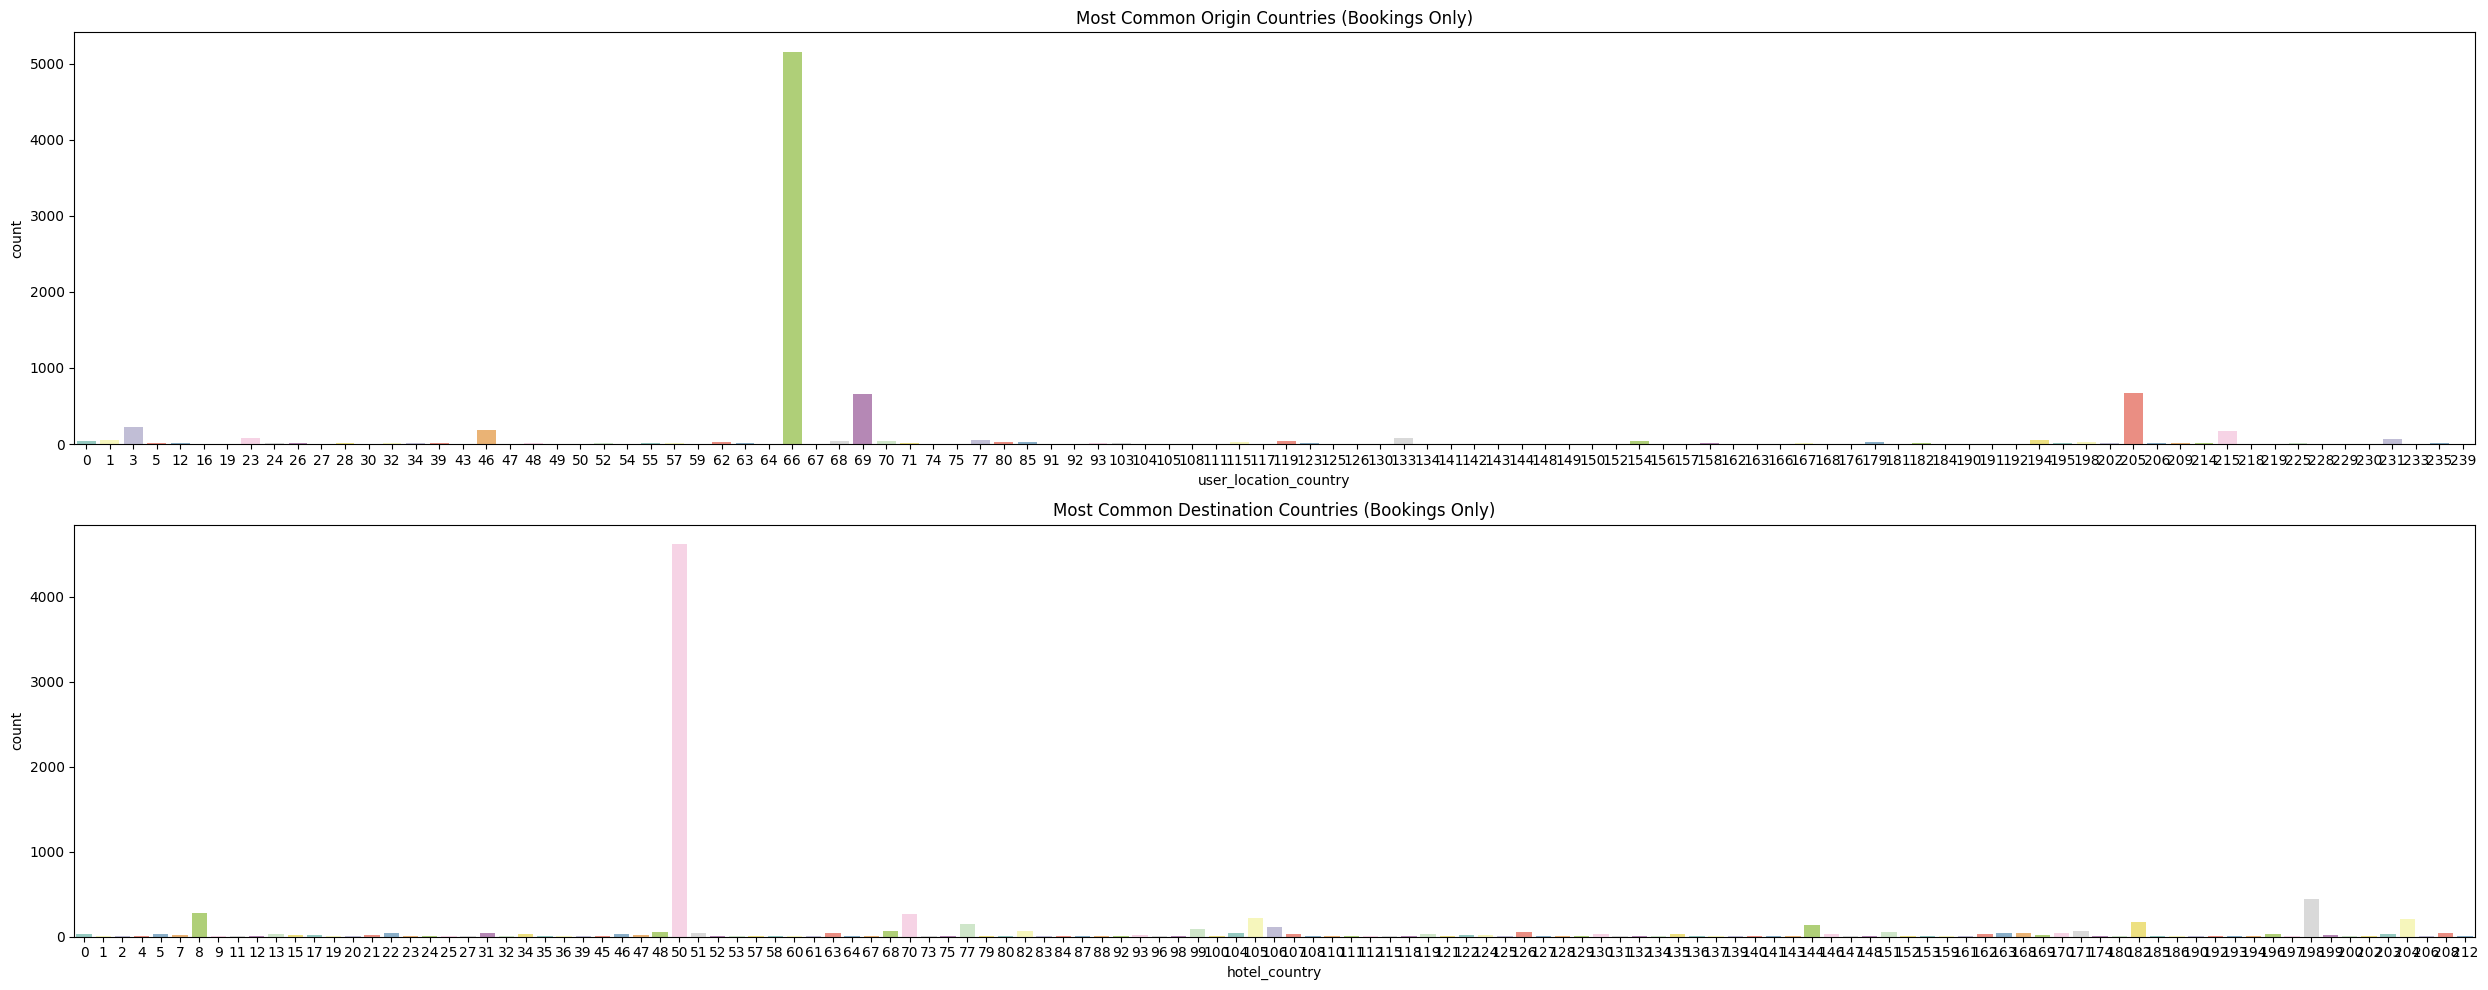

In [15]:
bookings_df = train_df[train_df["is_booking"] == 1]
#removing all the bookings that didnt happen i.e just clicks


fig, (axis1,axis2) = plt.subplots(2,1,figsize=(25,10))
# What are the most countries the customer travel from?
sns.countplot(
    x='user_location_country',
    data=bookings_df.sort_values(by='user_location_country'),
    ax=axis1,
    palette="Set3"
)
axis1.set_title("Most Common Origin Countries (Bookings Only)")

sns.countplot(
    x='hotel_country',
    data=bookings_df.sort_values(by='hotel_country'),
    ax=axis2,
    palette="Set3"
)
axis2.set_title("Most Common Destination Countries (Bookings Only)")

plt.tight_layout()
plt.show()


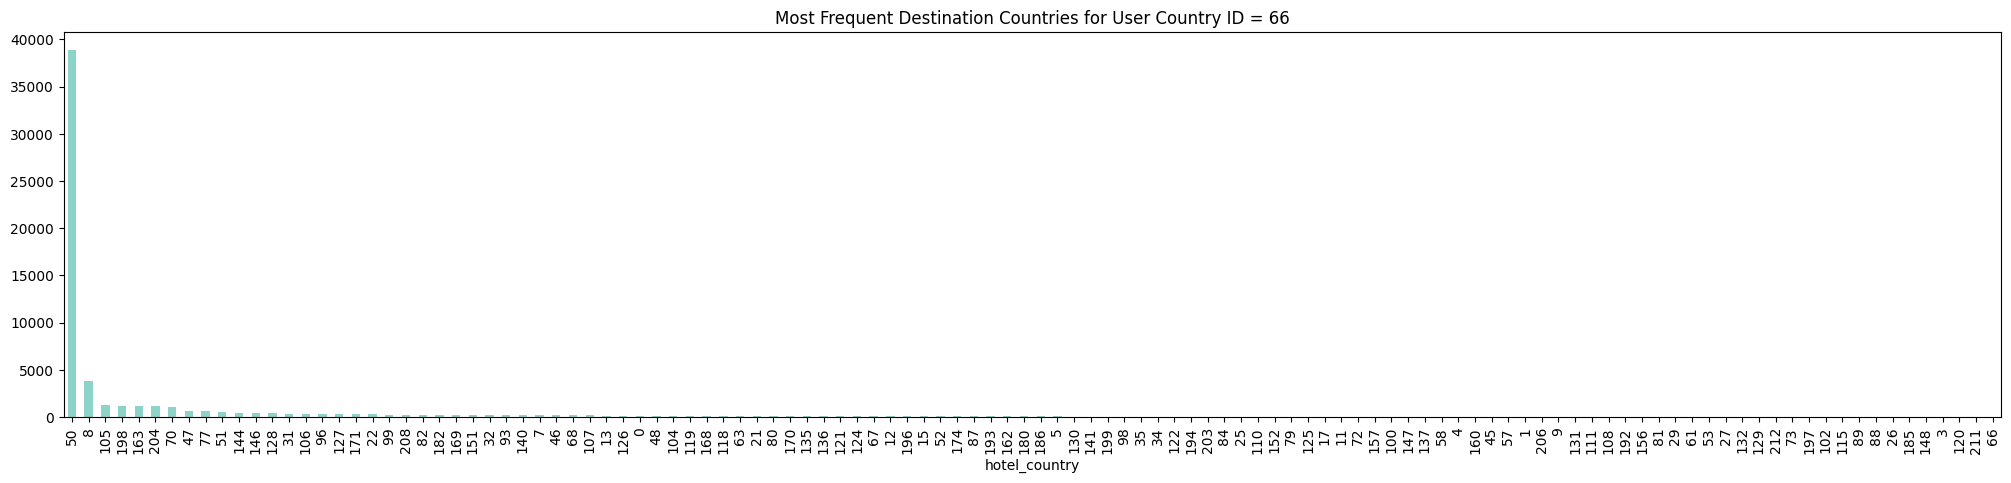

In [16]:
# 2. Where do most customers from a specific country (user_country_id) travel?
user_country_id = 66
country_customers = train_df[train_df["user_location_country"] == user_country_id]

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
country_customers["hotel_country"].value_counts().plot(
    kind='bar',
    colormap="Set3",
    ax=ax
)
ax.set_title(f"Most Frequent Destination Countries for User Country ID = {user_country_id}")
plt.show()


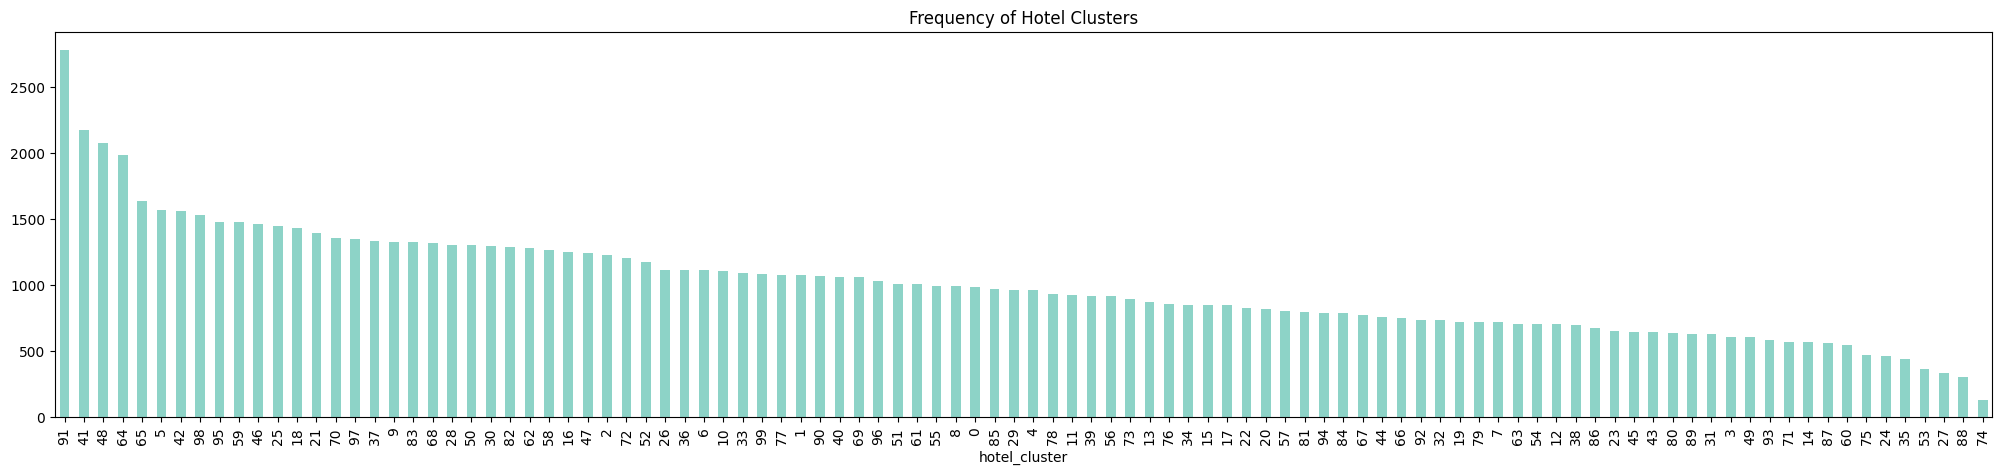

In [17]:
# 3. Frequency of each hotel_cluster in the entire dataset
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
train_df["hotel_cluster"].value_counts().plot(
    kind='bar',
    colormap="Set3",
    ax=ax
)
ax.set_title("Frequency of Hotel Clusters")
plt.show()

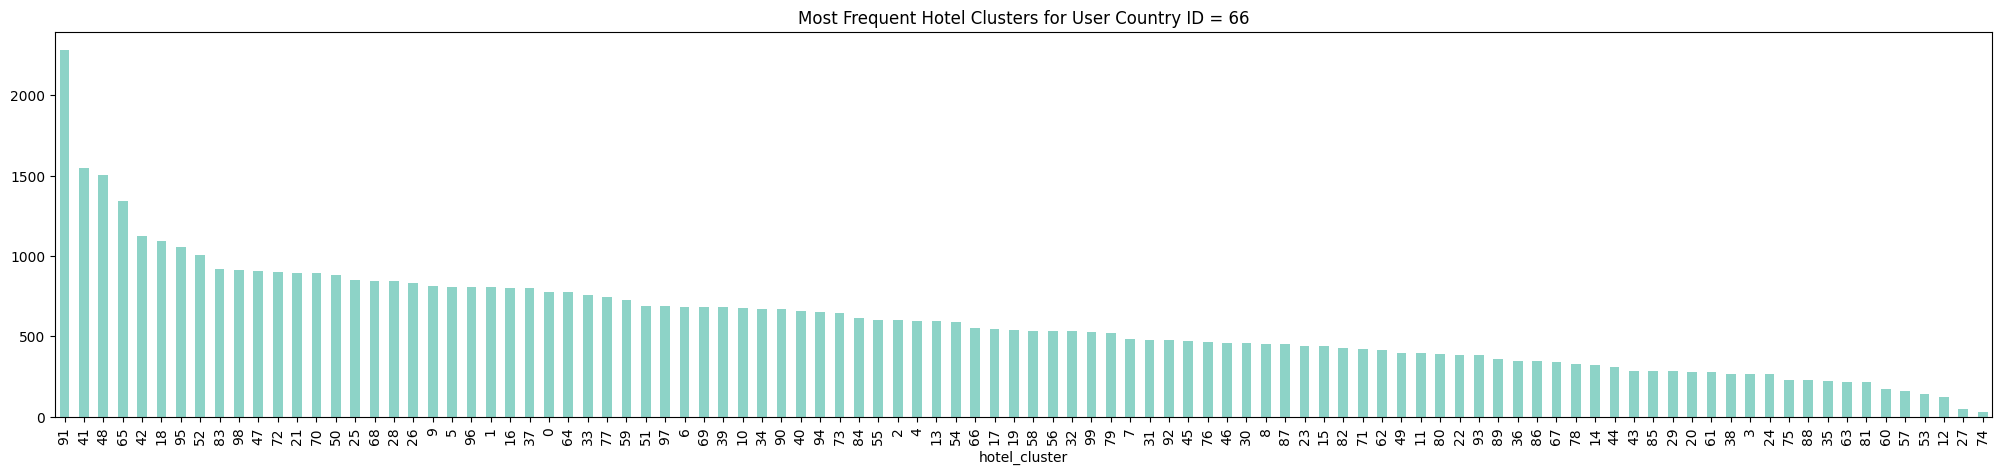

In [18]:
# 4. Most frequent hotel clusters booked by customers from user_country_id=66
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
customer_clusters = train_df[train_df["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(
    kind='bar',
    colormap="Set3",
    ax=ax
)
ax.set_title(f"Most Frequent Hotel Clusters for User Country ID = {user_country_id}")
plt.show()

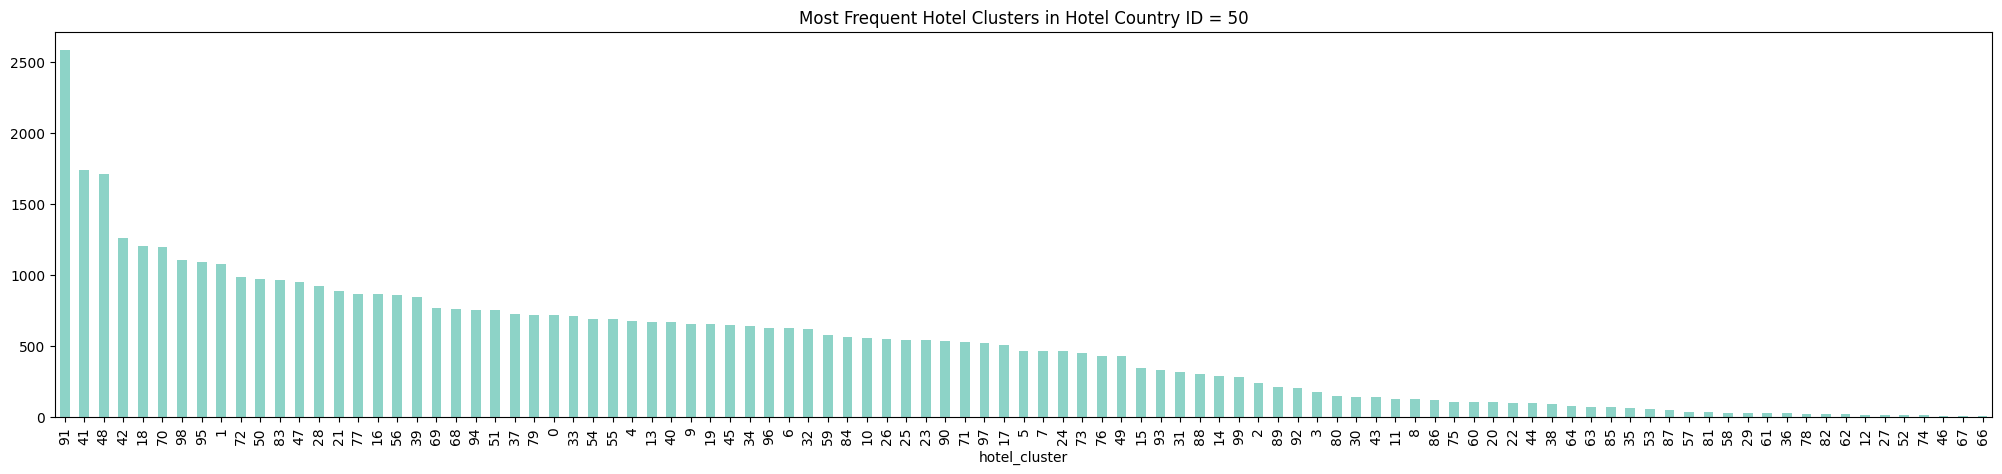

In [19]:
# 5. Most frequent hotel clusters in a given hotel_country =50 
country_id = 50
country_clusters = train_df[train_df["hotel_country"] == country_id]["hotel_cluster"]

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
country_clusters.value_counts().plot(
    kind='bar',
    colormap="Set3",
    ax=ax
)
ax.set_title(f"Most Frequent Hotel Clusters in Hotel Country ID = {country_id}")
plt.show()

C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\3945813028.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\3945813028.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


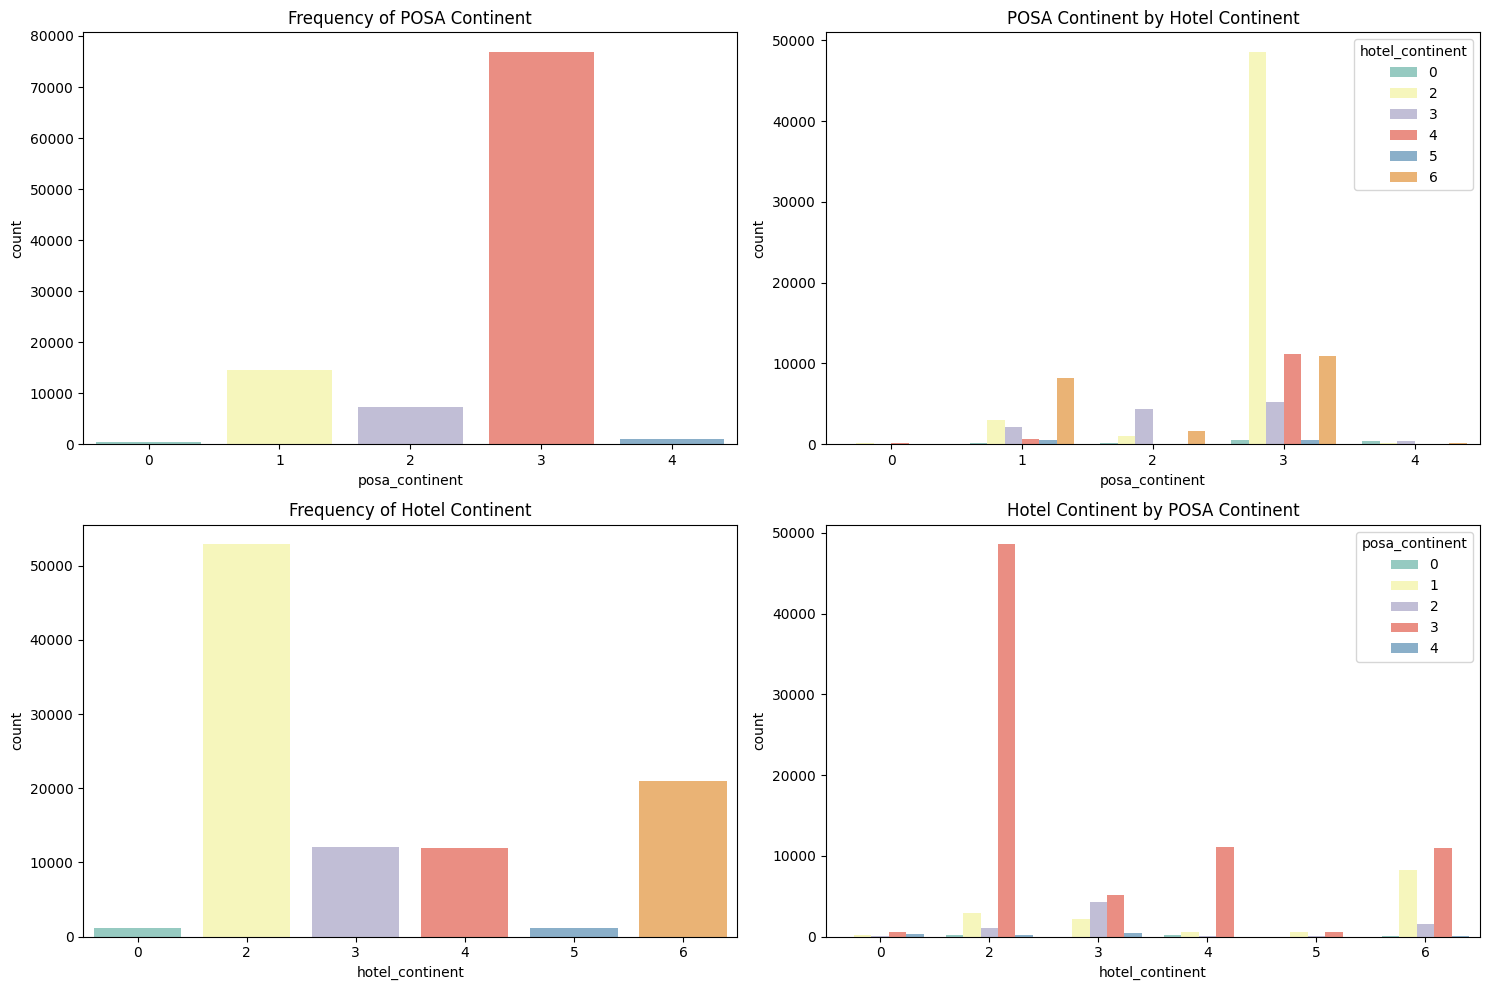

In [ ]:
# 6. Plot posa_continent & hotel_continent relationships
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(
    x='posa_continent',
    data=train_df,
    order=[0,1,2,3,4],
    palette="Set3",
    ax=axis1
)
axis1.set_title("Frequency of POSA Continent")

sns.countplot(
    x='posa_continent',
    hue='hotel_continent',
    data=train_df,
    order=[0,1,2,3,4],
    palette="Set3",
    ax=axis2
)
axis2.set_title("POSA Continent by Hotel Continent")

sns.countplot(
    x='hotel_continent',
    data=train_df,
    order=[0,2,3,4,5,6],
    palette="Set3",
    ax=axis3
)
axis3.set_title("Frequency of Hotel Continent")

sns.countplot(
    x='hotel_continent',
    hue='posa_continent',
    data=train_df,
    order=[0,2,3,4,5,6],
    palette="Set3",
    ax=axis4
)
axis4.set_title("Hotel Continent by POSA Continent")

plt.tight_layout()
plt.show()


These four subplots are examining two categorical variables—posa_continent (the continent from which a booking is made, i.e. point-of-sale) and hotel_continent (the continent where the hotel is located)—and how they relate to each other:

Top-Left 

Shows how often each posa_continent code appears in the dataset (i.e., which continents customers are booking from, overall).

Top-Right 

This indicates, for each point-of-sale continent, which hotel continents are being booked.

It helps reveal patterns such as whether users from posa_continent = 3 mostly book hotels in hotel_continent = 2, etc.

Bottom-Left 

Shows how often each hotel_continent code appears (i.e., the dataset’s overall distribution of hotels by continent).

Bottom-Right 

Displays hotel_continent frequencies, but split by posa_continent.

This reveals, for each hotel continent, which point-of-sale continents are most common among the customers booking those hotels.


C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\4248464982.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\4248464982.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


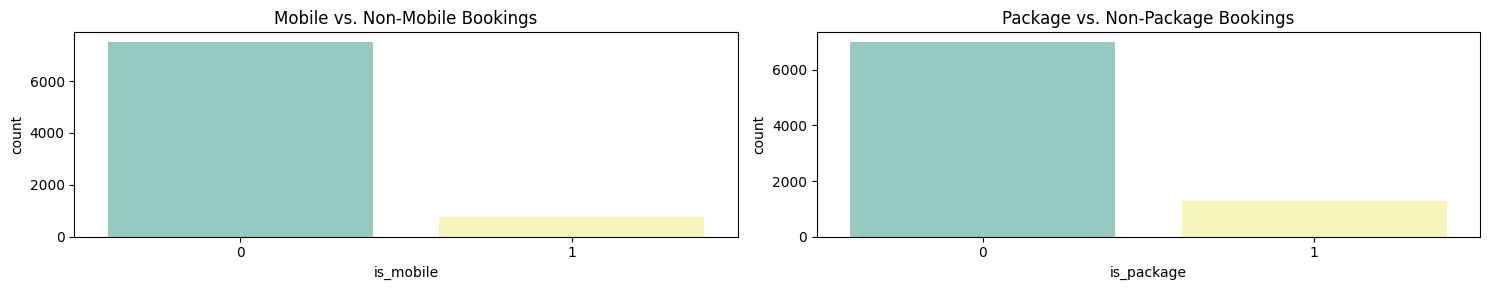

In [20]:
# 7. Plot frequency of mobile bookings & package bookings (for actual bookings only)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 3))

sns.countplot(
    x='is_mobile',
    data=bookings_df,
    order=[0,1],
    palette="Set3",
    ax=axis1
)
axis1.set_title("Mobile vs. Non-Mobile Bookings")

sns.countplot(
    x='is_package',
    data=bookings_df,
    order=[0,1],
    palette="Set3",
    ax=axis2
)
axis2.set_title("Package vs. Non-Package Bookings")

plt.tight_layout()
plt.show()



C:\Users\sikim\AppData\Local\Temp\ipykernel_37716\771920743.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


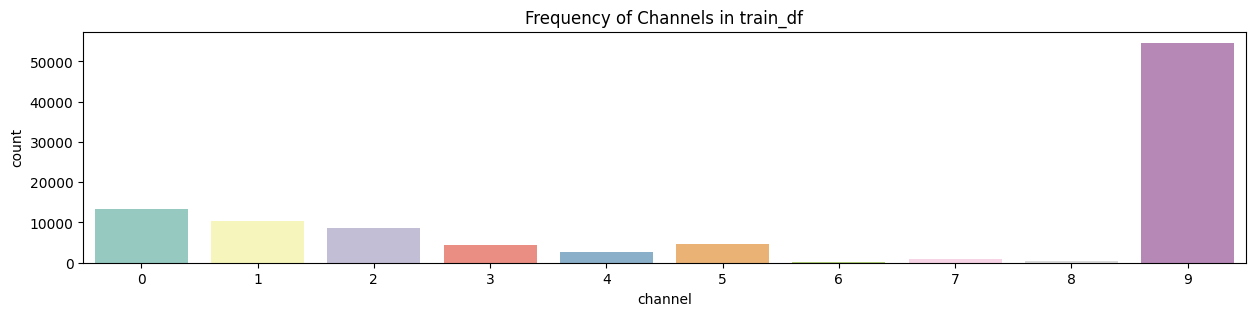

In [21]:
# 8. Most common booking channels
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.countplot(
    x='channel',
    order=list(range(0,10)),
    data=train_df,
    palette="Set3",
    ax=ax
)
ax.set_title("Frequency of Channels in train_df")
plt.show()

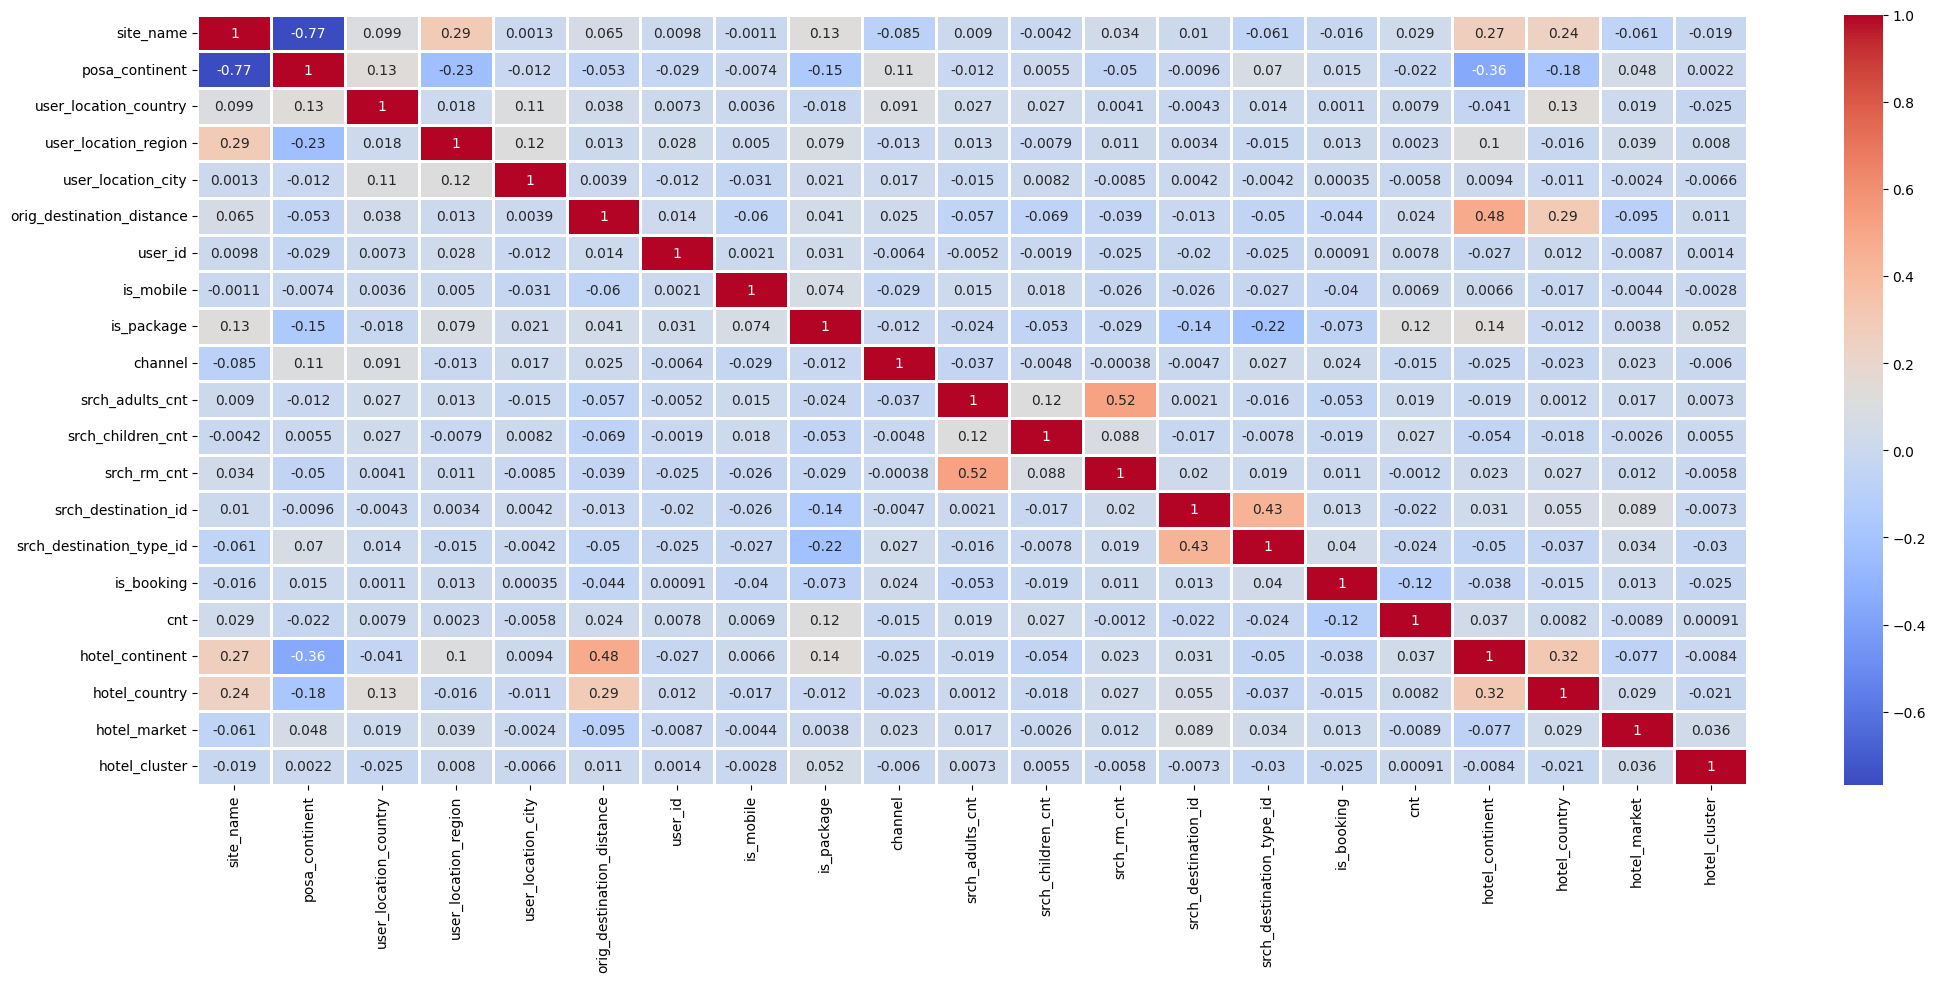

In [24]:
# heatmap
numeric_df = train_df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=2, ax=ax)
plt.show()